# Pipeline Analytics

### Model Building

By Mike Crowder
April 2019

## Introduction

One of the first things you want to do as a sales analytics professional is understand the sales forecasting process. Most companies will have no model driven approach. They will typically have a sales resource driven forecasting method, made up mostly "art". Our job is to bring some science to this process.

Sometimes they won't have the CRM data set up in as nice of a way like this data set is. If that is the case you will need to work with your BI team, or you will have to build processes to ensure good data from the CRM is captured. 

With that said, you are going to have to make some assumptions. First, and foremost you are going to have assume that sales resources are entering information into the CRM to their best ability. Some data science / analytics professionals will throw their hands up and refuse an attempt at modeling. I argue that in some organizations this is some of the most important analytics an organization can do. There are many areas in which a solid business science apporach would benefit. Namely we can create a better customer experince through better B2B sales forecasting.

For know, lets see if we can predict if an opportunity is going to sign or not. If we can figure that out then we should be able to figure out what features are most meaningful during the sales cycle.

### Our data

This dataset is sample data from [IBM's Watson Analytics](https://www.ibm.com/communities/analytics/watson-analytics-blog/sales-win-loss-sample-dataset/). The data is from a CRM system that has been run through a process to make it somewhat model ready for analysis. The purpose of the data is to discover patterns with sales wins and losses. This could allow a Sales Operations team to communicate to executive leadership what factors contribute to winning and losing. That allows the orgainization to be proactive and possibly change the outcome.

We first took this data and put it into a MySQL database and put some more features into the dataset. The SQL can be found [here](https://github.com/therealcrowder/salesPipelineForecasting/blob/master/modelSetUp.sql).

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('pipelineModel.csv')
df.head()

,Opp_Num,Channel,Region,IsCarAccessories,IsPerfNonAuto,IsTireWheels,IsCarElectronics,IsFieldsSales,IsReseller,IsInsideSalesTeam,...,Client_Size_Bin,Client_Emp_Size_Bin,Two_Year_Spend,IsCompKnown,IsCompUnknown,Ind_Days_Ratio,Val_Days_Ratio,Qual_Days_Ratio,Result,IsWon
0,1641984,Fields Sales,Northwest,1,0,0,0,1,0,0,...,5,5,0,0,1,0.69636,0.113985,0.154215,Won,1
1,1658010,Reseller,Pacific,1,0,0,0,0,1,0,...,3,5,0,0,1,0.00000,1.000000,0.000000,Loss,0
2,1674737,Reseller,Pacific,0,1,0,0,0,1,0,...,1,1,0,0,1,1.00000,0.000000,0.000000,Won,1
3,1675224,Reseller,Midwest,0,1,0,0,0,1,0,...,1,1,0,1,0,1.00000,0.000000,0.000000,Loss,0
4,1689785,Reseller,Pacific,1,0,0,0,0,1,0,...,1,1,0,0,1,0.00000,0.141125,0.000000,Loss,0


In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77968 entries, 0 to 77967
Data columns (total 27 columns):
Opp_Num                77968 non-null int64
Channel                77968 non-null object
Region                 77968 non-null object
IsCarAccessories       77968 non-null int64
IsPerfNonAuto          77968 non-null int64
IsTireWheels           77968 non-null int64
IsCarElectronics       77968 non-null int64
IsFieldsSales          77968 non-null int64
IsReseller             77968 non-null int64
IsInsideSalesTeam      77968 non-null int64
IsOtherSeller          77968 non-null int64
Stage_Duration         77968 non-null int64
Stage_Changes          77968 non-null int64
Days_To_Close          77968 non-null int64
Days_To_Qual           77968 non-null int64
Opp_NetRev             77968 non-null int64
Deal_Size_Bin          77968 non-null int64
Client_Size_Bin        77968 non-null int64
Client_Emp_Size_Bin    77968 non-null int64
Two_Year_Spend         77968 non-null int64
IsCompKno

We have 77,968 entries with 27 columns. Our target variable is going to be IsWon. IsWon is a 0 or 1 value in which a won opportunity is 1 and a lost opportunity is 0. We don't need result since IsWon is our target. Let's drop it.

In [4]:
if 'Result' in df:
    del df['Result']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77968 entries, 0 to 77967
Data columns (total 26 columns):
Opp_Num                77968 non-null int64
Channel                77968 non-null object
Region                 77968 non-null object
IsCarAccessories       77968 non-null int64
IsPerfNonAuto          77968 non-null int64
IsTireWheels           77968 non-null int64
IsCarElectronics       77968 non-null int64
IsFieldsSales          77968 non-null int64
IsReseller             77968 non-null int64
IsInsideSalesTeam      77968 non-null int64
IsOtherSeller          77968 non-null int64
Stage_Duration         77968 non-null int64
Stage_Changes          77968 non-null int64
Days_To_Close          77968 non-null int64
Days_To_Qual           77968 non-null int64
Opp_NetRev             77968 non-null int64
Deal_Size_Bin          77968 non-null int64
Client_Size_Bin        77968 non-null int64
Client_Emp_Size_Bin    77968 non-null int64
Two_Year_Spend         77968 non-null int64
IsCompKno

In [5]:
df.isnull().values.any() # Checks for null values

False

### Business Understanding

Lets take a few minutes and check some basic metrics on this data before we get into exploratory data analysis (EDA).

In [9]:
# the percentage of opportunties that were lost
len(df[df.IsWon==0])/len(df)*100.0

77.42663656884876

In [10]:
# Close or win rate
len(df[df.IsWon==1])/len(df)*100.0

22.573363431151243

This puts our win / close rate at 22.6% which is pretty standard in B2B sales. This means for every 100 bucks we put into the sales pipeline we actually sign around 23 bucks. We loose out on 77 of those dollars. Improving win rates by a few percentage points can mean millions of dollars for some sales organizations.

Let's look at some of the win rates within Channel and Region.

In [14]:
df_chan_grp = df.groupby(by = 'Channel')
print(df_chan_grp.IsWon.sum())
print('-----------------------------------')
print(df_chan_grp.IsWon.count())
print('-----------------------------------')
print((df_chan_grp.IsWon.sum() / df_chan_grp.IsWon.count())*100)

Channel
Fields Sales    6900
Other            528
Reseller        9578
Telecoverage      40
Telesales        554
Name: IsWon, dtype: int64
-----------------------------------
Channel
Fields Sales    37228
Other            2853
Reseller        34738
Telecoverage      619
Telesales        2530
Name: IsWon, dtype: int64
-----------------------------------
Channel
Fields Sales    18.534436
Other           18.506835
Reseller        27.572111
Telecoverage     6.462036
Telesales       21.897233
Name: IsWon, dtype: float64


Win rates do vary a little from channel to channel. The reseller channel appears to be the most effective in terms of win rate. The lowest is the telecoverage.
Now let's see what win rates look like from region to region using the same method.

In [16]:
df_reg_grp = df.groupby(by = 'Region')
print(df_reg_grp.IsWon.sum())
print('-----------------------------------')
print(df_reg_grp.IsWon.count())
print('-----------------------------------')
print((df_reg_grp.IsWon.sum() / df_reg_grp.IsWon.count())*100)

Region
Mid-Atlantic    1651
Midwest         5330
Northeast       1564
Northwest       2074
Pacific         3427
Southeast       2016
Southwest       1538
Name: IsWon, dtype: int64
-----------------------------------
Region
Mid-Atlantic     7566
Midwest         21013
Northeast        7356
Northwest        9548
Pacific         15117
Southeast        9222
Southwest        8146
Name: IsWon, dtype: int64
-----------------------------------
Region
Mid-Atlantic    21.821306
Midwest         25.365250
Northeast       21.261555
Northwest       21.721827
Pacific         22.669842
Southeast       21.860768
Southwest       18.880432
Name: IsWon, dtype: float64


There is not much variation between regions.

In [17]:
#Deal_Size_Bin
df_bin_grp = df.groupby(by = 'Deal_Size_Bin')
print(df_bin_grp.IsWon.sum())
print('-----------------------------------')
print(df_bin_grp.IsWon.count())
print('-----------------------------------')
print((df_bin_grp.IsWon.sum() / df_bin_grp.IsWon.count())*100)

Deal_Size_Bin
1    4825
2    4033
3    2945
4    2364
5    2120
6     851
7     462
Name: IsWon, dtype: int64
-----------------------------------
Deal_Size_Bin
1    12077
2    15109
3    11957
4    13622
5    18070
6     4931
7     2202
Name: IsWon, dtype: int64
-----------------------------------
Deal_Size_Bin
1    39.951975
2    26.692700
3    24.629924
4    17.354280
5    11.732153
6    17.258163
7    20.980926
Name: IsWon, dtype: float64


Variation does exist within the size of the opportunity. The sales force is better at winning smaller deals than they are at larger. This is common in B2B sales.

### Exploratory Data Analysis



In [20]:
import matplotlib.pyplot as plt
from pandas.tools.plotting import andrews_curves

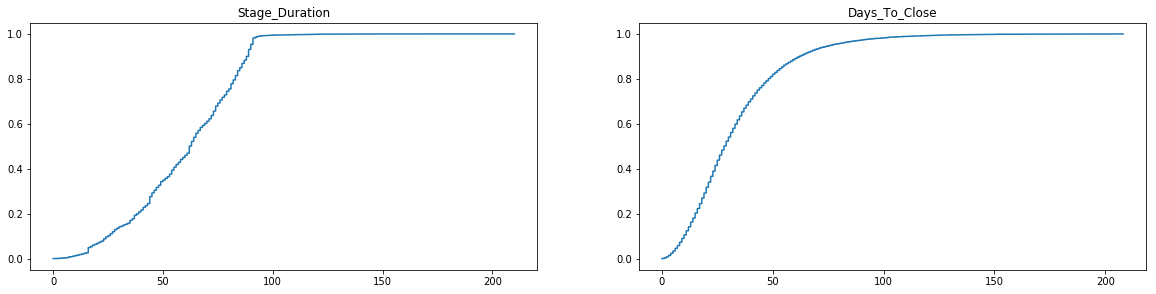

In [25]:
plt.figure(figsize = (20,10))
for fi, feature in enumerate(['Stage_Duration', 'Days_To_Close']):
    plt.subplot(2,2,fi+1)
    x_ax = np.sort(df[feature])
    y_ax = np.cumsum(x_ax)
    y_ax = y_ax/np.max(y_ax)
    plt.plot(x_ax,y_ax)
    plt.title(feature)
    
plt.show()

In [28]:
import seaborn as sns
cmap = sns.diverging_palette(220, 10, as_cmap=True)

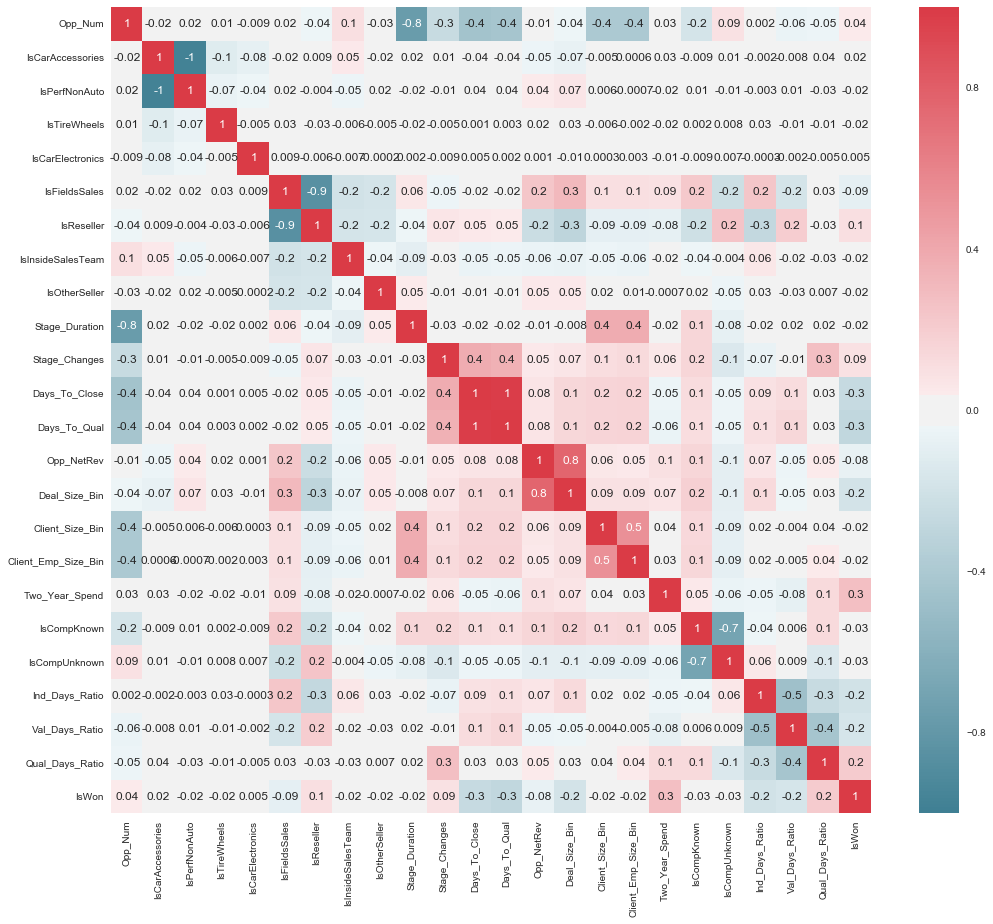

In [39]:
# Correlation Matrix
sns.set(style = "darkgrid")
f, ax = plt.subplots(figsize=(15,13))
sns.heatmap(df.corr(), cmap = cmap, annot = True, fmt = '.1g')
f.tight_layout()
plt.show()

When we look at everything together the correlation matrix is not telling us much. Let's try and isolate those opportunties that are won.